In [13]:
import dspy
import os
from dotenv import load_dotenv
load_dotenv()
load_dotenv('.secrets')


True

This implementation showcases how you could build AGoT using DSPy's composable abstractions. Let me explain the key components:
Core Components of the Implementation

1. DSPy Signatures and Modules for each AGoT Operation,

- `T0`: Generates initial thoughts (first layer)
- `Te`: Expands the graph with additional thoughts and edges
- `C`: Checks thought complexity to determine if recursion is needed
- `Eval`: Evaluates non-complex thoughts
- `Phi`: Synthesizes the final answer from the complete graph


2. Graph Structure: I use NetworkX to represent the directed acyclic graph (DAG) structure, with each node containing a Thought object that tracks important metadata.

3. Recursive Implementation: The _recursive_agot method implements the core algorithm described in the paper, including:

- Layer-by-layer generation of thoughts
- Complexity checking
- Recursive processing for complex thoughts
- Final answer synthesis


5. Visualization: The implementation includes a `visualize_graph` method to help understand the resulting reasoning structure.

### How This Maps to the Paper
The implementation closely follows the mathematical formalism in Section 2 of the paper:

- The heritage tracking system `(h = (s₀, s₁, ..., sₙ)) `is implemented using a list of layer and node index tuples
- The complexity function `C: T × G → {0, 1}` maps directly to the ComplexityChecker module
- The evaluation function `Eval: T × G → A` corresponds to the ThoughtEvaluator module
- The final synthesis function `Φ: G → T` is implemented as the FinalAnswerSynthesizer module

Implementation Notes

DSPy makes it easy to swap different language models as backends, which would be useful for testing different LLMs with AGoT.
The implementation focuses on the core AGoT algorithm rather than specific optimization techniques mentioned in the paper.
In a full implementation, you might want to add:

Better prompt engineering for each module
More sophisticated termination conditions
Parallelization for asynchronous thought evaluation
Metrics collection and evaluation against benchmarks

In [18]:
import dspy
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple, Optional
from dataclasses import dataclass
import logging

# Define the signature for the initial thoughts generation
class InitialThoughtsGenerator(dspy.Signature):
    """Generate initial thoughts for decomposing a complex problem."""
    query = dspy.InputField(desc="The original query or problem to solve")
    max_thoughts = dspy.InputField(desc="Maximum number of initial thoughts to generate")
    
    thoughts = dspy.OutputField(desc="A list of initial thoughts to tackle the problem")
    strategy = dspy.OutputField(desc="A strategy to guide the exploration of these thoughts")

# Define the signature for generating subsequent thoughts
class ThoughtExpander(dspy.Signature):
    """Generate additional thoughts based on the current graph state."""
    query = dspy.InputField(desc="The original query or problem to solve")
    current_graph = dspy.InputField(desc="Current state of the graph including all thoughts and their answers")
    max_new_thoughts = dspy.InputField(desc="Maximum number of new thoughts to generate")
    
    new_thoughts = dspy.OutputField(desc="A list of new thoughts to add to the graph")
    new_edges = dspy.OutputField(desc="A list of edges to add, specified as (source_id, target_id) tuples")
    strategy = dspy.OutputField(desc="A strategy to guide the exploration of these thoughts")

# Define a signature for complexity checking
class ComplexityChecker(dspy.Signature):
    """Determine if a thought is complex enough to warrant further decomposition."""
    thought = dspy.InputField(desc="The thought content to evaluate")
    graph_context = dspy.InputField(desc="Current state of the graph for context")
    
    is_complex = dspy.OutputField(desc="1 if the thought is complex and should be decomposed, 0 otherwise")
    reason = dspy.OutputField(desc="Reasoning for the complexity determination")

# Define a signature for thought evaluation
class ThoughtEvaluator(dspy.Signature):
    """Evaluate a thought to produce an answer or response."""
    thought = dspy.InputField(desc="The thought to evaluate")
    graph_context = dspy.InputField(desc="Current graph context to inform the evaluation")
    
    answer = dspy.OutputField(desc="Answer or response to the thought")

# Define a signature for final answer synthesis
class FinalAnswerSynthesizer(dspy.Signature):
    """Synthesize a final answer from the complete graph of thoughts."""
    query = dspy.InputField(desc="The original query or problem")
    graph = dspy.InputField(desc="The complete graph with all thoughts and answers")
    
    final_answer = dspy.OutputField(desc="The final answer to the original query")

# Create DSPy modules for each signature
class T0(dspy.Module):
    """Module for generating initial thoughts (T₀ in the paper)."""
    def __init__(self):
        super().__init__()
        self.generator = dspy.Predict(InitialThoughtsGenerator)
    
    def forward(self, query, max_thoughts=3):
        return self.generator(query=query, max_thoughts=max_thoughts)

class Te(dspy.Module):
    """Module for expanding thoughts with new nodes and edges (Tₑ in the paper)."""
    def __init__(self):
        super().__init__()
        self.expander = dspy.Predict(ThoughtExpander)
    
    def forward(self, query, current_graph, max_new_thoughts=3):
        return self.expander(
            query=query, 
            current_graph=current_graph,
            max_new_thoughts=max_new_thoughts
        )

class C(dspy.Module):
    """Module for complexity checking (C in the paper)."""
    def __init__(self):
        super().__init__()
        self.checker = dspy.Predict(ComplexityChecker)
    
    def forward(self, thought, graph_context):
        result = self.checker(thought=thought, graph_context=graph_context)
        return int(result.is_complex), result.reason

class Eval(dspy.Module):
    """Module for thought evaluation (Eval in the paper)."""
    def __init__(self):
        super().__init__()
        self.evaluator = dspy.Predict(ThoughtEvaluator)
    
    def forward(self, thought, graph_context):
        return self.evaluator(thought=thought, graph_context=graph_context).answer

class Phi(dspy.Module):
    """Module for final answer synthesis (Φ in the paper)."""
    def __init__(self):
        super().__init__()
        self.synthesizer = dspy.Predict(FinalAnswerSynthesizer)
    
    def forward(self, query, graph):
        return self.synthesizer(query=query, graph=graph).final_answer

# Define a data structure for thoughts
@dataclass
class Thought:
    id: str
    content: str
    layer: int
    strategy: str
    answer: Optional[str] = None
    is_complex: bool = False
    nested_graph: Optional[Any] = None
    
    def __str__(self):
        status = "COMPLEX" if self.is_complex else "EVALUATED"
        if self.answer:
            status = f"{status}: {self.answer[:50]}..." if len(self.answer) > 50 else f"{status}: {self.answer}"
        return f"Thought {self.id} [Layer {self.layer}]: {self.content[:50]}... ({status})"

# The main AGoT implementation
class AdaptiveGraphOfThoughts(dspy.Module):
    def __init__(self, lm=None, max_depth=1, max_layers=3, max_nodes=3):
        super().__init__()
        
        # Set language model
        if lm:
            dspy.configure(lm=lm)
        
        # Initialize the DSPy modules
        self.t0 = T0()
        self.te = Te()
        self.c = C()
        self.eval = Eval()
        self.phi = Phi()
        
        # Set limits
        self.max_depth = max_depth
        self.max_layers = max_layers
        self.max_nodes = max_nodes
    
    def _format_graph_for_context(self, G):
        """Format the graph state as a string for context in prompts."""
        result = []
        for node_id in nx.topological_sort(G):
            thought = G.nodes[node_id]['data']
            result.append(str(thought))
            
            # Add edge information
            for successor in G.successors(node_id):
                result.append(f"  ↳ connects to Thought {successor}")
                
        return "\n".join(result)
    
    def _recursive_agot(self, query, heritage, parent_graph=None, depth=0):
        """Recursive implementation of the AGoT algorithm."""
        # Initialize graph for this recursion level
        G = nx.DiGraph()
        print(f"depth={depth},heritage={heritage}")
        # Process layer by layer
        for layer in range(self.max_layers):            
            # Generate thoughts for this layer
            if layer == 0 and depth == 0:
                # Generate initial thoughts for the top-level graph
                result = self.t0(query, self.max_nodes)
                thoughts = result.thoughts
                strategy = result.strategy
                print(f"depth={depth},layer={layer}, thoughts={thoughts}, strategy={strategy}")
                # Add initial thoughts to the graph
                for i, thought_content in enumerate(thoughts):
                    thought_id = f"{layer}_{i}"
                    print(f"thought_id={thought_id} content={thought_content} layer={layer} strategy={strategy}")
                    G.add_node(thought_id, data=Thought(
                        id=thought_id,
                        content=thought_content,
                        layer=layer,
                        strategy=strategy
                    ))
                    
            elif layer == 0:
                # Generate initial thoughts for a nested graph
                parent_context = self._format_graph_for_context(parent_graph)
                result = self.t0(query, self.max_nodes)
                thoughts = result.thoughts
                strategy = result.strategy
                print(f"depth={depth},layer={layer}, thoughts={thoughts}, strategy={strategy}")
                # Add initial thoughts to the graph
                for i, thought_content in enumerate(thoughts):
                    thought_id = f"{layer}_{i}"
                    print(f"thought_id={thought_id} content={thought_content} layer={layer} strategy={strategy}")
                    G.add_node(thought_id, data=Thought(
                        id=thought_id,
                        content=thought_content,
                        layer=layer,
                        strategy=strategy
                    ))
            else:
                # Generate subsequent thoughts
                graph_context = self._format_graph_for_context(G)
                result = self.te(query, graph_context, self.max_nodes)
                new_thoughts = result.new_thoughts
                new_edges = result.new_edges
                strategy = result.strategy
                print(f"depth={depth},layer={layer}, thoughts={thoughts}, strategy={strategy}")
                # Add new thoughts to the graph
                for i, thought_content in enumerate(new_thoughts):
                    thought_id = f"{layer}_{i}"
                    print(f"thought_id={thought_id} content={thought_content} layer={layer} strategy={strategy}")
                    G.add_node(thought_id, data=Thought(
                        id=thought_id,
                        content=thought_content,
                        layer=layer,
                        strategy=strategy
                    ))
                
                # Add edges
                for source, target in new_edges:
                    if source in G and target in G:
                        G.add_edge(source, target)
            
            # Check if any thought in this layer is final
            for node_id, data in list(G.nodes(data=True)):
                thought = data['data']
                if thought.layer == layer:
                    # Check if this thought is complex
                    graph_context = self._format_graph_for_context(G)
                    is_complex, reason = self.c(thought.content, graph_context)
                    
                    if is_complex and depth < self.max_depth:
                        # Mark as complex
                        thought.is_complex = True
                        
                        # Recursively process this thought
                        nested_heritage = heritage + [(layer, int(node_id.split('_')[1]))]
                        answer, nested_graph = self._recursive_agot(
                            thought.content, 
                            nested_heritage, 
                            G, 
                            depth + 1
                        )
                        
                        # Store the result
                        thought.answer = answer
                        thought.nested_graph = nested_graph
                        
                    else:
                        # Evaluate the thought directly
                        thought.is_complex = False
                        thought.answer = self.eval(thought.content, graph_context)
            
            # Check if we need to add another layer
            if layer == self.max_layers - 1 or self._should_terminate(G):
                break
        
        # Synthesize final answer from this graph
        graph_context = self._format_graph_for_context(G)
        final_answer = self.phi(query, graph_context)
        
        return final_answer, G
    
    def _should_terminate(self, G):
        """Check if we should terminate early based on the graph state."""
        # This is a simple implementation - could be made more sophisticated
        # For example, check if a high-quality answer has already been found
        return False
    
    def forward(self, query):
        """Run the AGoT algorithm on the query."""
        final_answer, graph = self._recursive_agot(query, [])
        return {
            "answer": final_answer,
            "graph": graph
        }
    
    def visualize_graph(self, graph, figsize=(12, 8)):
        """Visualize the graph of thoughts."""
        plt.figure(figsize=figsize)
        
        # Create position layout
        pos = {}
        layer_counts = {}
        
        for node_id, data in graph.nodes(data=True):
            thought = data['data']
            layer = thought.layer
            
            if layer not in layer_counts:
                layer_counts[layer] = 0
            
            # Position nodes in layers
            pos[node_id] = (layer, -layer_counts[layer])
            layer_counts[layer] += 1
        
        # Draw nodes
        node_colors = []
        for node_id, data in graph.nodes(data=True):
            thought = data['data']
            if thought.is_complex:
                node_colors.append('orange')
            else:
                node_colors.append('skyblue')
        
        nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=700, alpha=0.8)
        nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5, arrows=True)
        
        # Draw labels
        labels = {}
        for node_id, data in graph.nodes(data=True):
            thought = data['data']
            labels[node_id] = f"{node_id}\n{thought.content[:20]}..."
        
        nx.draw_networkx_labels(graph, pos, labels, font_size=8)
        
        plt.title("Adaptive Graph of Thoughts")
        plt.axis('off')
        plt.tight_layout()
        plt.show()



Final Answer: El alcalde más reciente de San Sebastián de los Reyes es Narciso Romero, quien ha estado en el cargo desde 2015.


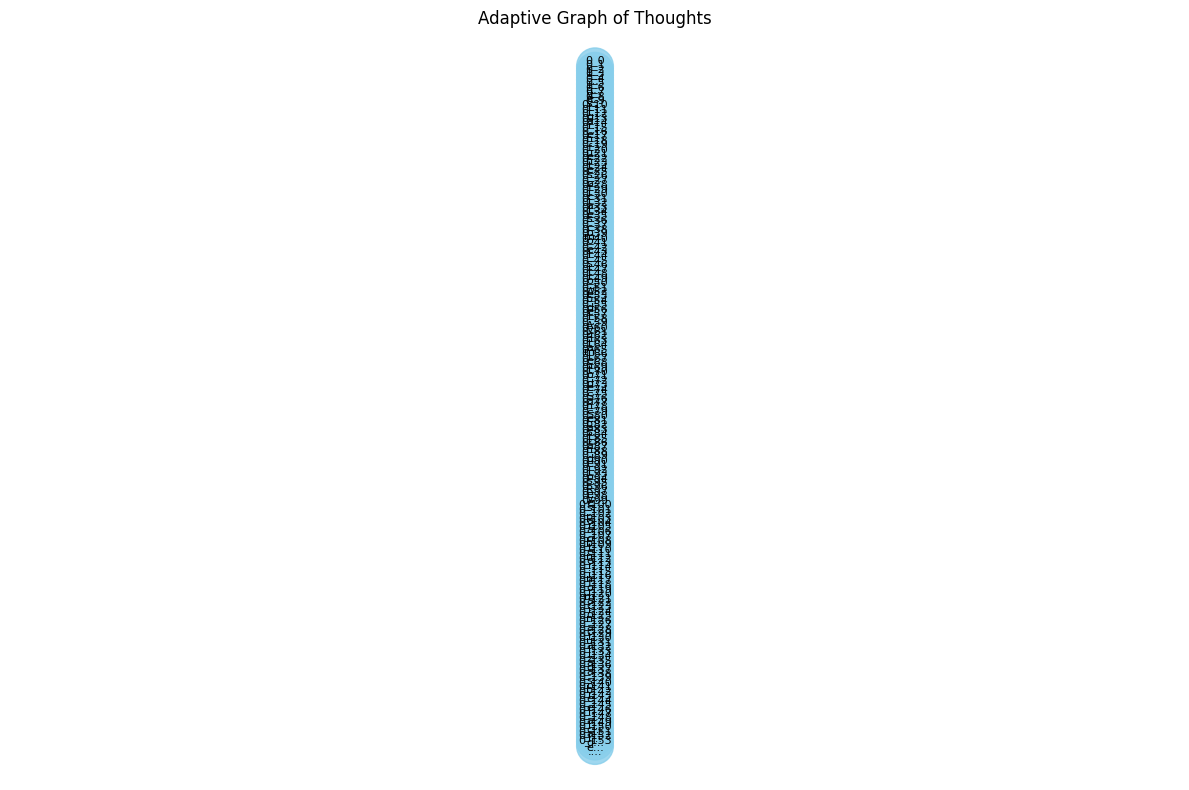

In [15]:
import dspy

lm = dspy.LM('gpt-4o-mini', api_key=os.getenv("OPENAI_API_KEY"))
agot = AdaptiveGraphOfThoughts(lm=lm, max_depth=1, max_layers=1, max_nodes=1)
# Run on a complex query
result = agot(query="Quien es el alcalde de San Sebastian de los Reyes mas reciente?")

# Get the answer and graph
answer = result["answer"]
graph = result["graph"]

print(f"Final Answer: {answer}")

# Visualize the graph
agot.visualize_graph(graph)


In [16]:

result

{'answer': 'El alcalde más reciente de San Sebastián de los Reyes es Narciso Romero, quien ha estado en el cargo desde 2015.',
 'graph': <networkx.classes.digraph.DiGraph at 0x1630bd790>}

In [17]:
dspy.inspect_history(n=10
                     )





[2025-02-25T18:22:53.635560]

System message:

Your input fields are:
1. `thought` (str): The thought to evaluate
2. `graph_context` (str): Current graph context to inform the evaluation

Your output fields are:
1. `answer` (str): Answer or response to the thought

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## thought ## ]]
{thought}

[[ ## graph_context ## ]]
{graph_context}

[[ ## answer ## ]]
{answer}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Evaluate a thought to produce an answer or response.


User message:

[[ ## thought ## ]]
a

[[ ## graph_context ## ]]
Thought 0_0 [Layer 0]: 1... (EVALUATED: The thought "1" does not provide sufficient contex...)
Thought 0_1 [Layer 0]: .... (EVALUATED: The thought is empty and does not provide any cont...)
Thought 0_2 [Layer 0]:  ... (EVALUATED: The thought appears to be a sequence of individual...)
Thought 0_3 [Layer 0]: I... (EVALUATED: The

In [20]:
agot = AdaptiveGraphOfThoughts(lm=lm, max_depth=1, max_layers=3, max_nodes=3)
# Run on a complex query
result = agot(query="Quien es el alcalde de San Sebastian de los Reyes mas reciente?")

# Get the answer and graph
answer = result["answer"]
graph = result["graph"]

print(f"Final Answer: {answer}")

# Visualize the graph
agot.visualize_graph(graph)

depth=0,heritage=[]
depth=0,layer=0, thoughts=1. Investigar en fuentes oficiales como el sitio web del Ayuntamiento de San Sebastián de los Reyes para obtener información actualizada sobre el alcalde.
2. Revisar noticias recientes en medios locales o nacionales que cubran la política de la región para identificar quién ocupa el cargo actualmente.
3. Consultar redes sociales o perfiles de políticos locales que puedan proporcionar información sobre el alcalde actual y sus actividades., strategy=La estrategia consiste en utilizar fuentes confiables y actualizadas para verificar la información sobre el alcalde. Se comenzará por consultar el sitio web oficial del Ayuntamiento, seguido de la búsqueda en medios de comunicación y redes sociales para corroborar la información y obtener un contexto más amplio sobre su gestión.
thought_id=0_0 content=1 layer=0 strategy=La estrategia consiste en utilizar fuentes confiables y actualizadas para verificar la información sobre el alcalde. Se comenzará

RateLimitError: litellm.RateLimitError: RateLimitError: OpenAIException - Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-nlRyAFTXZVIj5Ws33oGGalSK on tokens per min (TPM): Limit 200000, Used 193695, Requested 7218. Please try again in 273ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}